In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math, glob, copy, pickle, warnings
from time import process_time
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings("ignore")
from sklearn import preprocessing

# Feature Dropping

In [3]:
def dropping(x_vector, y_vector, input_percentage):
    #global mi_pcc, mi_pcc_sort
    # remove the lowest k percentage features from mi_pcc
    cutoff = int(math.floor(input_percentage*(x_vector.shape[1])))

    fecture_vector = list(x_vector.columns)
    removed_feature_list, selected_features = [], []
    for i in range(0, cutoff):
      for j in range(0, mi_pcc_sort.shape[0]):
            if(mi_pcc_sort[i]==mi_pcc[j]):
                removed_feature_list.append(fecture_vector[j])
    
    for k in fecture_vector:
        st = 1
        for i in removed_feature_list:
            if(i==k):
                st = 0
                break
        if(st==1):
            selected_features.append(k)
    
    data = x_vector[selected_features]

    mi_selected_features = mutual_info_classif(data, y_vector)
    return data, mi_selected_features
def hybrid(x_vector, y_vector, percentage):
    """
    Input:  x_vector: 2D array shape of (no_of_samples, no_of_features)
            y_vector: 1D array shape of (no_of_sample, )
    Output: data: which is equal to x_vector shape of (no_of_samples, no_of_selected_features)
    Functionality:  Select the top k percentage of features based on mi and pcc.
                    Adopted from paper: https://sci-hub.se/10.1109/calcon49167.2020.9106516
    """
    #global mi_selected_features
    global sort_features_list, mi_pcc, mi_pcc_sort

    feature_pcc, selected_features, removed_feature_list = [], [], []
    a = 0.9
    
    # Drop constant features
    x_vector = x_vector.loc[:,x_vector.apply(pd.Series.nunique) != 1]

    # calculate the mutual information between class and feature vector
    mi = mutual_info_classif(x_vector, y_vector)

    # calculate the pcc between feature to feature
    fecture_vector = list(x_vector.columns)
    corr_matrix = x_vector.corr()
    corr_matrix = abs(np.array(corr_matrix))
    for i in range(0, len(corr_matrix)):
        feature_pcc.append((np.sum(corr_matrix[i]) - 1)/(len(corr_matrix)-1))
    
    # compute the final rank value for feature vector
    mi_pcc = a*mi - (1-a)*np.array(feature_pcc)

    # remove the lowest k percentage features from mi_pcc
    cutoff = int(math.floor(percentage*(x_vector.shape[1])))

    # sort the array in ascending order
    mi_pcc_sort = mi_pcc.copy()
    mi_pcc_sort.sort()

    sort_features_list = []
    mi_sorted = []
    for i in range(0, mi_pcc_sort.shape[0]):
        for j in range(0, mi_pcc.shape[0]):
            if(mi_pcc_sort[i]==mi_pcc[j]):
                sort_features_list.append(fecture_vector[j])
                #mi_sorted.append()
                mi_pcc[j] = 100000000
                break
    
    
    removed_feature_list = sort_features_list[0:cutoff]
    selected_features = sort_features_list[cutoff:]
    
    print("No of removed features: ", len(removed_feature_list))
    print("No of selected features: ", len(selected_features))
    if(x_vector.shape[1]>1000):
        # microarray dataset
        pass
    else:
        print("Deleted feature vectors list: ", removed_feature_list)
        print("Selected feature vectors list: ", selected_features)

    # create the x data based on selected feature vector
    data = x_vector[selected_features]

    """
    compute the mutual information of the selected feature vector.
    which will be using as an 3rd obejectine function for the GA and SA.
    """
    mi_selected_features = mutual_info_classif(data, y_vector)
    return data, mi_selected_features

In [4]:
def check_overlapping_for_cluster(pop):
    """
    Input: population, population_fitness, population_accuracy
    Output: population, population_fitness, population_accuracy
    Functionality:  Takes an population and checks if there are
                    multiple copies of a individual then remove
                    all these copies.
    """
    enable_output = False # to show the results
    pop_copy = pop.copy()
    remove_index = []
    for i in range(0, len(pop)):
        counter = i
        for j in pop[i+1:]:
            counter += 1
            """
            If two individuals are same then store these same
            indiviual's index number for delete.
            """
            if(isEqual(pop[i], j)):
                remove_index.append(counter)
    remove_index = list(set(remove_index))
    remove_index.sort(reverse = True)
    
    # delete the copy individuals from populations
    for i in remove_index:
        del pop_copy[i]
    
    if(enable_output):
        if(len(pop_copy) == len(pop)):
            print("\nNo overlapping has been occured!!")
            print("Current population size: ", len(pop_copy))
        else:
            print("Overlapping occured. Current population size: ", len(pop_copy))
    
    return pop_copy

In [5]:
def hammingDist(ind1, ind2):
    """
    Input: two individual ind1 and ind2
    Output: an integer value
    Functionality: compute the hamming distance between two individuals
    """
    i, count = 0, 0
    while(i < len(ind1)):
        if(ind1[i] != ind2[i]):
            count += 1
        i += 1
    return count

def cal_similarity(ind_datapoint, cluster_datapoint, ind_acc, cluster_acc):
    esp = 0.7
    # compute the hamming distance between the cluster_datapoint and ind_datapoint
    hamming_dist = hammingDist(cluster_datapoint, ind_datapoint)
    # difference between classification accuracy
    diff_acc = abs(ind_acc-cluster_acc)
    similarity = esp*(1/diff_acc) + (1-esp)*(1/hamming_dist)
    return similarity

def get_random_pop(size):
    random_population = []
    for i in range(0, size):
        random_population.append(get_individual())
    # check there is any overlapping in between or not
    random_population = check_overlapping_for_cluster(random_population)
    return random_population


def CBPI(population_size):
    """
    Input: an 2D array of shape (population_size, no_of_features)
    Output: an 2D array of shape (population_size, no_of_features)
    Functionality: Cluster based population generation
    """
    population, population_fit, population_acc = [], [], []
    random_pop = get_random_pop(4*population_size)
    no_cluster_center = population_size # m = no_cluster_center i.e. should be 
    
    """
    Randomly Initialize the cluster center
    """
    cluster_centers = random.sample(random_pop, no_cluster_center)

    """
    now discard the cluster centers individuals from populations
    """
    remove_index = []
    for i in range(0, len(random_pop)):
        flag = 0
        for j in range(0, len(cluster_centers)):
            if(isEqual(random_pop[i], cluster_centers[j])):
                flag = 1
                break
        if(flag==1):
            remove_index.append(i)

    remove_index.sort(reverse = True)
    for i in remove_index:
        del random_pop[i]
    
    #------------------------------------------------------------

    # find the fitness of the non-cluter center individual
    non_cluster_pop_fit, non_cluster_pop_acc = [], []

    for i in range(0, len(random_pop)):
        ind_fit_acc = getFitness(random_pop[i])
        non_cluster_pop_fit.append(ind_fit_acc[0])
        non_cluster_pop_acc.append(ind_fit_acc[1])

    # find the fitness of the cluster individual
    cluster_pop_fit, cluster_pop_acc = [], []
    for i in range(0, len(cluster_centers)):
        ind_fit_acc = getFitness(cluster_centers[i])
        cluster_pop_fit.append(ind_fit_acc[0])
        cluster_pop_acc.append(ind_fit_acc[1])

    #-----------------------------------------------------------
    # Assign the individual to a particular cluster
    ind_belongs_to_cluter = []
    for i in range(0, len(random_pop)):
        ind_fit = non_cluster_pop_fit[i]  # fitness of the current individual
        ind_acc = non_cluster_pop_acc[i]  # accuracy of the current individual

        similar_list  = []
        for j in range(0, no_cluster_center):
            cluster_fit = cluster_pop_fit[j]  # fitness of the cluster center
            cluster_acc = cluster_pop_acc[j] # accuracy of the cluster center 
            
            # compute similarity between the cluster center and the current individual
            similarity = cal_similarity(random_pop[i], cluster_centers[j], ind_acc, cluster_acc)
            similar_list.append(similarity)
        # get the cluster no which has the highest similarity
        ind_belongs_to_cluter.append(similar_list.index(max(similar_list)))
    #-----------------------------------------------------------    
    #print(ind_belongs_to_cluter)
    """
    Now we will be taking only one individual out the cluster 
    to do so there may be some cluster which has only one point
    then at that case don't compute the part-2 rather than that
    directly add that cluster center into the final ouput population.
    """
    li1 = set(ind_belongs_to_cluter)
    li2 = [i for i in range(population_size)]
    direct_add = list(set(li1) - set(li2)) + list(set(li2) - set(li1))
    direct_add.sort(reverse=True)
    # directly add then into final population from cluster center
    for d in direct_add:
        population.append(cluster_centers[d])
        population_fit.append(cluster_pop_fit[d])
        population_acc.append(cluster_pop_acc[d])
    #----------------------------------------------------------



    #-----------------------------------------------------------
    for i in range(0, len(cluster_centers)):
        status = False
        # if the cluster has only the cluster center then don't comput the nested loop
        for temp in direct_add:
            if(temp==i):
                status = True
                break
        if(status):
            continue
        cluster_fit = cluster_pop_fit[i]

        # go for the individual belongs to this cluster
        ind_index = []
        same_cluster_ind_fit = []
        for j in range(0, len(ind_belongs_to_cluter)):
            if(ind_belongs_to_cluter[j]==i):
                ind_index.append(j)
                #store this individuals fitness value
                same_cluster_ind_fit.append(non_cluster_pop_fit[j])
        # compute the maximum fitness
        if(max(same_cluster_ind_fit)>cluster_fit):
            # put the heighest fit individual to the population cluster
            put_index = ind_index[same_cluster_ind_fit.index(max(same_cluster_ind_fit))]
            population.append(random_pop[put_index])
            population_fit.append(non_cluster_pop_fit[put_index])
            population_acc.append(non_cluster_pop_acc[put_index])
        else:
            # put the cluster center into the population
            population.append(cluster_centers[i])
            population_fit.append(cluster_pop_fit[i])
            population_acc.append(cluster_pop_acc[i])
    #-------------------------------------------------------------------
    return population, population_fit, population_acc

# SA

In [6]:
#================================ From Indivisuals to selected feature vector===============================
def get_features(ind):
    """
    Input: takes an individual of shape (no_of_features, )
    Output: retuns name of the selecetd features.
    Functionality: converts and indiviual form to an selected feature vector form.
    """
    # store all the feature vectors of the given dataset
    all_features = list(x_train.columns)
    features_names = []
    for i in range(0, len(ind)):
        if(ind[i]==1):
            features_names.append(all_features[i])
    return features_names
#============================================================================================

#=============================  Fitness Function   ==========================================
def getFitness(individual):
    """
    Input: takes an individual of shape (no_of_features, )
    Output: retuns a tuple of (fitnesss_value, accuracy)
    Functionality: computes the fitness value of the given individual.
    """
    global gamma, y, mi_selected_features
    sum_mi = 0

    # calculate the total no of features in the dataset.
    total_no_features = int(x_train.shape[1])

    # get the name of selected feature vectors from individual 
    selected_features = get_features(individual)

    # calculate the no of selected feature vector
    selected_no_fectures = len(selected_features)

    # If the no of selected feature vector is 0 then return (0, 0)
    if(selected_no_fectures==0):
        return (0, 0)

    # 1st objective function
    _classifier = KNeighborsClassifier(n_neighbors = 5)
    x_train_temp = x_train[selected_features]
    x_test_temp = x_test[selected_features]
    _classifier.fit(x_train_temp, y_train)
    predictions = _classifier.predict(x_test_temp)
    accuracy = accuracy_score(y_true = y_test, y_pred = predictions)

    """
    3rd objective:
    compute the mutual information between the selected feature vector and class vector
    """
    for i in range(0, len(individual)):
        if(individual[i]==1):
            sum_mi += mi_selected_features[i]
    sum_mi = sum_mi/selected_no_fectures
    obj_3rd = sum_mi

    # calculate the final multiobjective fitness function
    my_fitness = alpha*accuracy + (1-alpha)*(gamma * ((total_no_features - selected_no_fectures)/total_no_features) + (1-gamma)*obj_3rd)
    
    return (my_fitness, accuracy)
#============================================================================================

In [7]:
class Simulated_Annealing(object):
    
    def __init__(self, max_iter = 100):
        """
        Intialization of the Hyperparameters of SA.
        """
        self.max_iter = max_iter
        self.total_features = int(x_train.shape[1])
        # create a dataframe
        self.logfile = pd.DataFrame(columns=['fitness','accuracy', 'no_of_features'])

    def isValidInd(self, individual):
        """
        Input: Individual of shape (no_of_selected_feature, )
        Output: binary i.e. True or False
              False: If we have the Invalid Individual
              True: If we have the alid Individual
        Functionality:  checks whether a individual is valid or not.
                      validity means if we have the 0 in all gene positions 
                      of an individual then that individual is not valid.
        """
        if((set(individual))=={0}):
            return False
        else:
            return True

    def find_new_individual(self, individual):
        """
        Input:  Current Individual of shape (no_of_selected_feature, )
        Output: New state i.e. Next Individual of shape (no_of_selected_feature, )
        Functionality: generates a new solution/individual from the current solution/individual
        """
        """
        changes: instead of middle point now it's a random point in between 
        int(0.30*total_features) and celling(0.70total_features)
        """
        position = []
        #methods = "middle"
        methods = "30-40"

        if(methods == "30-40"):
            # methods = "30-40"
            temp_1 = int(self.total_features*0.30)
            temp_2 = int(self.total_features*0.70)
            end_point = random.randint(temp_1, temp_2)

            position.append(random.randint(0, end_point))
            position.append(random.randint(end_point+1, self.total_features-1))
        else:
            # methods = "middle"
            position.append(random.randint(0, math.floor(self.total_features/2)))
            position.append(random.randint(math.floor(self.total_features/2)+1, self.total_features-1))
        
        for i in range(0, 2):
            if individual[position[i]] == 1:
                individual[position[i]] = 0
            else:
                individual[position[i]] = 1
        
        # check wheather the new state/individual is valid or not
        if(self.isValidInd(individual)):
            return individual
        else:
            # if the individual is not valid then generate the new state or new indivisual
            return get_individual()

    def result(self):
        """
        show the result after the convergence.
        """
        # calculate the no of selected features in optimal individual
        no_of_selected_features = 0
        for i in range(0, len(self.best_individual)):
            if(self.best_individual[i] == 1):
                no_of_selected_features += 1
        
        # get the selected feature vectors name
        selected_features = get_features(self.best_individual)
        _classifier = KNeighborsClassifier(n_neighbors = 5)
        x_train_temp = x_train[selected_features]
        x_test_temp = x_test[selected_features]
        _classifier.fit(x_train_temp, y_train)
        predictions = _classifier.predict(x_test_temp)
        accuracy = accuracy_score(y_true = y_test, y_pred = predictions)

        return self.best_individual, self.best_fitness, accuracy, no_of_selected_features, self.logfile

    def simulated_annealing(self, initial_indivsual):
        """
        Input: initial_indivsual, intitial individual of shape(no_of_features, )
        """
        sa_accuracy, fitness, iter_values, all_ind = [], [], [], []
        my_iter = 0
        
        # get the initial fitness
        initial_fitness, intial_acc = getFitness(initial_indivsual)

        current_individual, current_fitness, current_acc = initial_indivsual, initial_fitness, intial_acc
        self.initial_indivsual = current_individual
        
        run_wise_fitness, run_wise_accuracy, run_wise_no_of_features = [], [], []

        """
        initial temp is equal to 2*N
        where N is the total no of features
        """
        temp = 2*self.total_features

        while my_iter < self.max_iter:
            next_individual = self.find_new_individual(current_individual)
            next_fitness, next_accuracy = getFitness(next_individual)
            if current_fitness > next_fitness:
                # i.e. bad moves then accept new individual with some probability value
                e_x = (my_iter/temp)*((current_fitness-next_fitness)/current_fitness)
                probabilty = math.exp(-e_x)
                random_value = random.random()
                if random_value <= probabilty: # then accept that bad move
                    current_individual = next_individual
                    current_fitness = next_fitness
                    current_acc = next_accuracy
            else:
                # directly accepts the new state
                current_individual = next_individual
                current_fitness = next_fitness
                current_acc = next_accuracy
            # store the fitness, accuracy and no_of_features in a dataframe and then at the end store as a csv file
            run_wise_fitness.append(current_fitness)
            run_wise_accuracy.append(current_acc)
            run_wise_no_of_features.append(len(get_features(current_individual)))
            

            all_ind.append(np.array(current_individual))
            fitness.append(current_fitness)
            my_iter += 1
            temp = 0.93*temp # 0.93 is the another hyperparameter i.e. it is a cooling factor
        self.best_individual = list(all_ind[fitness.index(max(fitness))])
        self.best_fitness = max(fitness)
        self.logfile['accuracy'] = run_wise_accuracy
        self.logfile['fitness'] = run_wise_fitness
        self.logfile['no_of_features'] = run_wise_no_of_features

In [8]:
def isEqual(ind1, ind2):
    """
    Input: two lists (Indivisual_1, Indivisual_2)
    Output: boolen value i.e. True or False
    Functionality:  If two individual ind1 and ind2 are same then 
                    output is True.
                    otherwise False
    """
    status = False
    for k in range(0, len(ind1)):
        if(ind1[k] == ind2[k]):
            status = True
            continue
        else:
            status = False
            break
    return status

def check_overlapping(pop, pop_fitness, pop_acc):
    """
    Input: population, population_fitness, population_accuracy
    Output: population, population_fitness, population_accuracy
    Functionality:  Takes an population and checks if there are
                    multiple copies of a individual then remove
                    all these copies.
    """
    enable_output = False # to show the results
    pop_copy = pop.copy()
    pop_fitness_copy = pop_fitness.copy()
    pop_acc_copy = pop_acc.copy()
    remove_index = []
    for i in range(0, len(pop)):
        counter = i
        for j in pop[i+1:]:
            counter += 1
            """
            If two individuals are same then store these same
            indiviual's index number for delete.
            """
            if(isEqual(pop[i], j)):
                remove_index.append(counter)
    remove_index = list(set(remove_index))
    remove_index.sort(reverse = True)
    
    # delete the copy individuals from populations
    for i in remove_index:
        del pop_copy[i]
        del pop_fitness_copy[i]
        del pop_acc_copy[i]
    
    if(enable_output):
        if(len(pop_copy) == len(pop)):
            print("\nNo overlapping has been occured!!")
            print("Current population size: ", len(pop_copy))
        else:
            print("Overlapping occured. Current population size: ", len(pop_copy))
    
    return pop_copy, pop_fitness_copy, pop_acc_copy

def get_individual():
    """
    Input: 
    Output: individual
    Functionality:  generate an individual.
                    genes are randomly generated.
    """
    individual = []
    for i in range(0, x_train.shape[1]):
        gene = random.randint(0, 1)
        individual.append(gene)
    return individual

def get_population(population_size):
    global sa_all_population_run_wise
    """
    Input: an integer, population_size
    Output: SA_generated_population, SA_generated_population_fitness,
            SA_generated_population_accuarcy 
    Functionality:  generate population with twice of the actual population size.
                    then remove the repetating indivisuals.
                    then choose the best individuals out of the current population.
    """
    population, population_fitness, population_accuracy  = [], [], []
    while(len(population)<=population_size):
        cbpi_pop, cbpi_pop_fit, cbi_pop_acc = CBPI(population_size)
        # First generate population by SA
        sa_all_population_run_wise = [] # store the run_wise data
        # store the intial population also, so that we can run the same for the GA also
        with open('cbpi_pop.txt', 'w') as f:
            for item in cbpi_pop:
                f.write("%s\n" % item)

        for i in range(0, population_size):
            #ind = get_individual() # get the randomly generated individual
            ind = cbpi_pop[i]#cbpi_population_sa_ga[i]#
            SA = Simulated_Annealing() # get the SA object
            SA.simulated_annealing(ind) # pass the randomly genrated individual to the SA
            best_individual, fitness, acc, no_of_selected_features, sa_logfile = SA.result() # get the SA generated results
            sa_all_population_run_wise.append(sa_logfile)
            population.append(best_individual) # store the SA generated output indivisual 
            population_fitness.append(fitness) # store the SA generated fitness value of the final individual 
            population_accuracy.append(acc) # store the SA generated accuarcy value of the final individual 
      
        # check the repetation is there or not
        population, population_fitness, population_accuracy = check_overlapping(population, population_fitness, population_accuracy)
        #break
    
        """
        If the current population size is equal to the desired population size then return, else
        choose the best indivisuals out the of the current population.
        """

        if(len(population)==population_size):
            return population, population_fitness, population_accuracy
        else:
            """
            Now choose the best indivisuals out the of the current population.
            Sort by accuracy first then sort by fitness.
            To implement this use dataframe.
            """
            sa_population, sa_fitness, sa_acc = [], [], []
            
            #store in a dataframe format
            sa_df = create_dataframe(population, population_accuracy, population_fitness)

            # sort the dataframe based on first Accuarcy then based on Fitness in decending order.
            sa_df.sort_values(["Accuracy", "Fitness"], axis=0, ascending=False, inplace=True)
            
            # store all of the columns i.e. Individual, Accuracy, Fitness
            sa_population_all = list(sa_df['Individual'])
            sa_acc_all = list(sa_df['Accuracy'])
            sa_fitness_all = list(sa_df['Fitness'])

            # create the population containg best individuals
            for i in range(0, population_size):
                sa_population.append(list(sa_population_all[i]))
                sa_fitness.append(sa_fitness_all[i])
                sa_acc.append(sa_acc_all[i])
            
            return sa_population, sa_fitness, sa_acc

In [9]:
def create_dataframe(ind, acc, fit):
    """
    Input: individual, accuarcy and fitness
    output: return a dataframe
    """
    data = {'Individual':['123'], 'Accuracy':['123'], 'Fitness': ['123']}
    df = pd.DataFrame(data) # Create DataFrame
    for i in range(0, len(ind)):
        df.loc[len(df.index)] = [ind[i], acc[i], fit[i]]
    df = df.drop(0) # Now delete the fist row
    return df

def concatenate_dataframe(df1, df2):
    """
    Input: two dataframes
    Output: concatenates two input dataframes
    """
    frames = [df1, df2]
    concatenated_dataframe = pd.concat(frames)
    return concatenated_dataframe

# GA

In [10]:
#==============================================================================================
class Solution():    
    #structure of the solution 
    def __init__(self):
        self.num_features = None
        self.population_size = None
        self.num_generations = None
        self.best_individual = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None
        self.history = None
#==============================================================================================
class Genetic_Algorithm(object):

    def __init__(self, max_iter):
        global num_generations
        self.population_size = len(population)
        self.save_conv_graph = False
        pop = np.ones((len(population), len(population[0])))
        for i in range(0, pop.shape[0]):
            pop[i] = np.array(population[i])
        self.population = pop
        self.fitness = np.array(sa_fitness)
        self.num_features = x_train.shape[1]
        self.accuracy = np.array(sa_accuracy)
        self.Leader_fitness = float("-inf")
        self.Leader_accuracy = float("-inf")
        self.history = []
        self.cur_iter = 0
        self.num_generations = num_generations
        self.max_iter = max_iter

        self.solution = None
        self.verbose = False

        self.prob_cross = 0.7
        self.prob_mut = 0.3
        self.cross_limit = 10
        self.prob_cross_max = 0.7
        self.prob_cross_min = 0.6
        self.prob_mut_max = 0.4
        self.prob_mut_min = 0.3
        self.logfile = pd.DataFrame(columns=['fitness','accuracy', 'no_of_features'])

    def sort_agents(self, agents, fitness, accuracy):
        # sort the agents according to fitness
        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()
        sorted_accuracy = accuracy[idx].copy()
        return sorted_agents, sorted_fitness, sorted_accuracy
    
    def get_fitness(self, pop):
        """
        Input: population, 2D array
        Output: an 1D array
        Functionality: calculate the fitness of the population.
        """
        fitness, accuracy = [], []
        for i in range(0, len(pop)):
            ind_fitness = getFitness(pop[i])
            fitness.append(ind_fitness[0])
            accuracy.append(ind_fitness[1])
        accuracy = np.array(accuracy)
        return np.array(fitness), accuracy

    def initialize(self):
        # set the objective function
        self.weight_acc = 0.9
        self.population, self.fitness, self.accuracy = self.sort_agents(agents = self.population, fitness = self.fitness, accuracy = self.accuracy)
        # save the best fittest individual and it's fitness value
        self.Leader_agent, self.Leader_fitness = self.population[0], self.fitness[0]

    def save_details(self):
        # save some details of every generation
        cur_obj = {
            'population': self.population,
            'fitness': self.fitness,
            'accuracy': self.accuracy,
        }
        self.history.append(copy.deepcopy(cur_obj))

    def display(self):
        # display the current generation details
        if self.verbose:
            for i in range(0, len(self.population)):
                print("agents = ", self.population[i], " fitness = ", self.fitness[i], " accuracy = ", self.accuracy[i])

    def plot(self):
        # plot the convergence graph
        fig = plt.figure(figsize=(10, 8))
        avg_fitness, avg_accuracy = [], []
        for cur in self.history:
            avg_fitness.append(np.mean(cur['fitness']))
            avg_accuracy.append(np.mean(cur['accuracy']))

        plt.plot(np.arange(len(avg_fitness)), avg_fitness,  color = 'r', label = 'fitness')
        plt.plot(np.arange(len(avg_accuracy)), avg_accuracy,  color = 'g', label = 'accuracy')
        plt.plot(np.arange(len(avg_accuracy)), self.max_fit_per_gen,  color = 'orange', label = 'max-fit')
        plt.plot(np.arange(len(avg_accuracy)), self.max_acc_per_gen,  color = 'b', label = 'max-acc')
        plt.xlabel('Number of Generations')
        plt.ylabel('Average Fitness and Accuracy')
        plt.title('Convergence Curve')
        plt.legend()
        plt.show()
        return fig

    def post_processing(self):
        # post processing steps
        fit_acc = self.get_fitness(self.population)
        self.fitness = fit_acc[0]
        self.accuracy = fit_acc[1]
        self.population, self.fitness, self.accuracy = self.sort_agents(agents = self.population, fitness = self.fitness, accuracy = self.accuracy)
        
        if(self.fitness[0] > self.Leader_fitness):
            self.Leader_fitness = self.fitness[0]
            self.Leader_agent = self.population[0, :]
            self.Leader_accuracy = self.accuracy[0]

    def save_solution(self):
        # create a solution object
        self.solution = Solution()
        self.solution.population_size = self.population_size
        self.solution.num_generations = self.num_generations

        # update attributes of solution
        self.solution.best_individual = self.Leader_agent
        self.solution.best_fitness = self.Leader_fitness
        self.solution.best_accuracy = self.Leader_accuracy
        self.solution.final_population = self.population
        self.solution.final_fitness = self.fitness
        self.solution.final_accuracy = self.accuracy

    def crossover(self, parent_1, parent_2):
        # perform crossover with crossover probability prob_cross
        num_features = parent_1.shape[0]
        child_1 = parent_1.copy()
        child_2 = parent_2.copy()

        for i in range(num_features):
            if(np.random.rand() < self.prob_cross):
                child_1[i] = parent_2[i]
                child_2[i] = parent_1[i]

        return child_1, child_2

    def mutation(self, chromosome):
        # perform mutation with mutation probability prob_mut
        num_features = chromosome.shape[0]
        mut_chromosome = chromosome.copy()

        for i in range(num_features):
            if(np.random.rand() < self.prob_mut):
                mut_chromosome[i] = 1-mut_chromosome[i]
        
        return mut_chromosome

    def roulette_wheel(self, fitness):
        # perform roulette wheel selection
        maximum = sum([f for f in fitness])
        selection_probs = [f/maximum for f in fitness]
        return np.random.choice(len(fitness), p=selection_probs)

    def cross_mut(self):
        # perform crossover, mutation and replacement
        count = 0
        #print('Crossover-Mutation phase starting....')

        while(count < self.cross_limit):
            #print('\nCrossover no. {}'.format(count+1))
            id_1 = self.roulette_wheel(self.fitness)
            id_2 = self.roulette_wheel(self.fitness)

            if(id_1 != id_2):
                child_1, child_2 = self.crossover(self.population[id_1, :], self.population[id_2, :])
                child_1 = self.mutation(child_1)
                child_2 = self.mutation(child_2)

                child = np.array([child_1, child_2])
                child_fit_acc = self.get_fitness(child)
                child_fitness = child_fit_acc[0]
                chile_acc = child_fit_acc[1]
                child, child_fitness, chile_acc = self.sort_agents(child, child_fitness, chile_acc)

                for i in range(2):
                    for j in reversed(range(self.population_size)):
                        if(child_fitness[i] > self.fitness[j]):
                            #print('child {} replaced with chromosome having id {}'.format(i+1, j+1))
                            self.population[j, :] = child[i]
                            self.fitness[j] = child_fitness[i]
                            self.accuracy[j] = chile_acc[i]
                            break
                
                count+= 1

            else:
                pass
                """
                print('Crossover failed....')
                print('Restarting crossover....\n')
                """
    
    def get_results(self):
        # sort the dataframe based on first Accuarcy then based on Fitness in decending order.
        self.ga_df.sort_values(["Accuracy", "Fitness"], axis=0, ascending=False, inplace=True)
        
        # store all of the columns i.e. Individual, Accuracy, Fitness
        best_ind = list(self.ga_df['Individual'])[0]
        best_ind_acc = list(self.ga_df['Accuracy'])[0]
        best_ind_fit = list(self.ga_df['Fitness'])[0]

        # caculate the no of features selected in best individual
        count = 0
        for i in best_ind:
            if(i==1):
                count += 1

        return best_ind, best_ind_acc, best_ind_fit, count

    def run(self):
        global ga_run_wise_accuracy, ga_run_wise_fitness, ga_run_wise_no_of_features
        self.max_fit_per_gen, self.max_acc_per_gen = [], []
        self.initialize()   # initialize the algorithm
        self.save_details() # save the initial details
        self.max_fit_per_gen.append(np.max(self.fitness))
        self.max_acc_per_gen.append(np.max(self.accuracy))

        # create the dataframe to store the population and it's fitness value and the accuracy
        self.ga_df = create_dataframe(self.population, self.accuracy, self.fitness)
        ga_run_wise_accuracy, ga_run_wise_fitness, ga_run_wise_no_of_features = [], [], []
        for generation in range(self.num_generations):    # while the end criterion is not met
            ga_run_wise_accuracy.append(self.accuracy)
            ga_run_wise_fitness.append(self.fitness)
            for ind in self.population:
                ga_run_wise_no_of_features.append(len(get_features(ind)))
            #print(self.fitness)
            #print(self.accuracy)

            self.cross_mut()

            self.cur_iter+= 1

            # store all the population and fitness and the accuracy in the dataframe format
            # add current individual, accuracy and fitness in the dataframe
            self.ga_df_next = create_dataframe(self.population, self.accuracy, self.fitness)
            self.ga_df = concatenate_dataframe(self.ga_df_next, self.ga_df)

            """
            # Adopt the crossover and mutation probability
            f_dash is the fitness of one of the parent
            f_avg is the average fitness of the population.
            f is the fitness of the one for mutation. i.e. kind of a thershold value.
            """

            if(cross_mut == "adaptive"):
                f_avg = np.mean(self.fitness)
                # for crossover
                f_dash = self.fitness[random.randint(0, int(self.fitness.shape[0]/2))]
                if(f_dash > f_avg):
                    self.prob_cross = self.prob_cross_max - generation*((self.prob_cross_max - self.prob_cross_min)/self.num_generations)
                else:
                    self.prob_cross = self.prob_cross_max
            
                # for mutation
                f = 0.80
                if(f>f_avg):
                    self.prob_mut = self.prob_mut_min + generation*((self.prob_mut_max - self.prob_mut_min)/self.num_generations)
                else:
                    self.prob_mut = self.prob_mut_min
            else:
                pass

            #----------------------------------------------

            self.post_processing()          # do the post processing steps
            self.display()                  # display the details of 1 iteration
            self.save_details()             # save the details
            self.max_fit_per_gen.append(np.max(self.fitness))
            self.max_acc_per_gen.append(np.max(self.accuracy))

        fit_acc = getFitness(self.Leader_agent)
        self.Leader_fitness = fit_acc[0]
        self.Leader_accuracy = fit_acc[1]

        self.save_solution()

        if(self.save_conv_graph):
            fig = self.plot()
            fig.savefig('convergence_curve_genetic_algo.jpg')

        #print('\n-------------  Leader Agent  ---------------')
        #print('Fitness: {}'.format(self.Leader_fitness))
        #print('Number of Features: {}'.format(int(np.sum(self.Leader_agent))))
        #print('----------------------------------------\n')
        
        return self.save_solution()

In [11]:
def get_data(file_name):
    global mi_selected_features, dichotomas, sort_features_list, percentage
    """
    Input: file name
    Output: x_train, x_test, y_train, y_test
    """
    try:
        df = pd.read_csv(file_name, header = None)
        tot_features = len(df.columns)-1
        total_features = tot_features
        x, y = df[df.columns[:tot_features]], df[df.columns[-1]]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
        _classifier = KNeighborsClassifier(n_neighbors = 5)
        _classifier.fit(x_train, y_train)
        predictions = _classifier.predict(x_test)
        total_acc = accuracy_score(y_true = y_test, y_pred = predictions)
    except:
        df = pd.read_csv(file_name)
        tot_features = len(df.columns)-1
        total_features = tot_features
        x, y = df[df.columns[:tot_features]], df[df.columns[-1]]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
        _classifier = KNeighborsClassifier(n_neighbors = 5)
        _classifier.fit(x_train, y_train)
        predictions = _classifier.predict(x_test)
        total_acc = accuracy_score(y_true = y_test, y_pred = predictions)

    print("Total features: ",total_features)
    print("Accuracy, taking all features: ", total_acc*100)

    # if total no of features less than 90% then don't need to drop features
    if(dropping_way == 'static'):
        # drop 25 % of the data directly
        #percentage = 0.995
        x_train, mi_selected_features = hybrid(x_train, y_train, percentage)
        fecture_vectors = list(x_train.columns)
        x_test = x_test[fecture_vectors]
        return x_train, x_test, y_train, y_test
    else:
        if(total_features<10):
            return x_train, x_test, y_train, y_test
        elif(total_features<20):
            # if no of features less than 20 then do only one time 25% features dropping
            # feature dropping
            percentage = 0.25
            x_train, mi_selected_features = hybrid(x_train, y_train, percentage)
            fecture_vectors = list(x_train.columns)
            x_test = x_test[fecture_vectors]
            return x_train, x_test, y_train, y_test
        else:
            if(dichotomas):
                run_time = 1
                while(True):
                    if(x_train.shape[1]<20):
                        # don't revome any more features
                        break
                    # drop25
                    percentage25 = 0.25
                    if(run_time==1):
                        x_train25, mi_selected_features25 = hybrid(x_train, y_train, percentage25)
                        fecture_vectors = list(x_train25.columns)
                        x_test25 = x_test[fecture_vectors]

                    else:
                        x_train25, mi_selected_features25 = dropping(x_train, y_train, percentage25)
                        fecture_vectors = list(x_train25.columns)
                        x_test25 = x_test[fecture_vectors]
                    
                    run_time += 1

                    _classifier = KNeighborsClassifier(n_neighbors = 5)
                    _classifier.fit(x_train25, y_train)
                    predictions = _classifier.predict(x_test25)
                    acc25 = accuracy_score(y_true = y_test, y_pred = predictions)

              
                    # drop50
                    percentage50 = 0.50
                    x_train50, mi_selected_features50 = dropping(x_train, y_train, percentage50)
                    
                    fecture_vectors = list(x_train50.columns)
                    x_test50 = x_test[fecture_vectors]

                    _classifier = KNeighborsClassifier(n_neighbors = 5)
                    _classifier.fit(x_train50, y_train)
                    predictions = _classifier.predict(x_test50)
                    acc50 = accuracy_score(y_true = y_test, y_pred = predictions)

                    # drop50
                    percentage75 = 0.75
                    x_train75, mi_selected_features75 = dropping(x_train, y_train, percentage75)
                    fecture_vectors = list(x_train75.columns)
                    x_test75 = x_test[fecture_vectors]

                    _classifier = KNeighborsClassifier(n_neighbors = 5)
                    _classifier.fit(x_train75, y_train)
                    predictions = _classifier.predict(x_test75)
                    acc75 = accuracy_score(y_true = y_test, y_pred = predictions)

                    ##
                    print("Dropping: ", total_acc, acc25, acc50, acc75)
                    if(acc50 >= acc25):
                        
                        if(acc75 >= acc50):
                            # drop 75% of the data
                            x_train, x_test = x_train75, x_test75
                            total_acc = acc75
                            mi_selected_features = mi_selected_features75
                            cutoff = int(math.floor(0.75*(x_train.shape[1])))
                            sort_features_list = sort_features_list[0:cutoff]
                            print(acc75)
                          
                          
                        else:
                            #drop 50% of the data
                            x_train, x_test = x_train50, x_test50
                            total_acc = acc50
                            mi_selected_features = mi_selected_features50
                            cutoff = int(math.floor(0.50*(x_train.shape[1])))
                            sort_features_list = sort_features_list[0:cutoff]
                            print(acc50)
                  
                    elif(acc25>=total_acc):
                        #drop 25% of the data
                        x_train, x_test = x_train25, x_test25
                        total_acc = acc25
                        mi_selected_features = mi_selected_features25
                        cutoff = int(math.floor(0.25*(x_train.shape[1])))
                        sort_features_list = sort_features_list[0:cutoff]
                        print(acc25)
                    else:
                        break
                    run_time = run_time +1
                  
                return x_train, x_test, y_train, y_test
        
            else:
                percentage = 0.25
                # drop the features until the convergence criteria satisfied
                while(True):
                    #print(percentage, total_acc)
                    if(x_train.shape[1]<20):
                        # don't revome any more features
                        break
                    x_train, mi_selected_features  = hybrid(x_train, y_train, percentage)
                    fecture_vectors = list(x_train.columns)
                    x_test = x_test[fecture_vectors]

                    _classifier = KNeighborsClassifier(n_neighbors = 5)
                    _classifier.fit(x_train, y_train)
                    predictions = _classifier.predict(x_test)
                    total_acc_new = accuracy_score(y_true = y_test, y_pred = predictions)
                    if(total_acc_new >= total_acc):
                        #total_acc = total_acc_new
                        x_train_to_save, x_test_to_save, y_train_to_save, y_test_to_save = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()
                        #percentage = percentage + 0.05
                    else:
                        break
                return x_train, x_test, y_train, y_test

In [12]:
def display_results():
    """
    display the results
    """
    if(x_train.shape[1]>1000):
        print("Fitness", "\t"*3, "Accuracy")
        for i in range(0, len(population)):
            print(sa_fitness[i], sa_accuracy[i])
    else:
        print("Individual", "\t"*5, "Fitness", "\t"*3, "Accuracy")
        for i in range(0, len(population)):
            print(population[i], sa_fitness[i], sa_accuracy[i])

In [14]:
files = glob.glob("/content/drive/MyDrive/Feature Selection/dataset/microarray/*.csv")
dropping_verbose = False
dichotomas = True
dropping_way = 'static'
print(files)
#Adaptive
cross_mut = 'adaptive'

data_type = "microarray"
# Calculate the percentage of the
no_of_wanted_features = 20
percentage = (100 - (no_of_wanted_features/5147)*100)/100
total_run = 10
file_name = files[0]
print(file_name)
x_train, x_test, y_train, y_test = get_data(file_name)
mi_selected_features = mutual_info_classif(x_train, y_train)
# Train with all the features
_classifier = KNeighborsClassifier(n_neighbors = 5)
_classifier.fit(x_train, y_train)
predictions = _classifier.predict(x_test)
total_acc_new = accuracy_score(y_true = y_test, y_pred = predictions)
print('Accuarcy with all the features: ', total_acc_new*100)

['/content/drive/MyDrive/Feature Selection/dataset/microarray/Leukaemiamattest.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/SRBCTGENE.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/dlbcl.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/braintumor.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/AMLGSE2191.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/MLLmattest.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/prostatemattest.csv', '/content/drive/MyDrive/Feature Selection/dataset/microarray/lung.csv']
/content/drive/MyDrive/Feature Selection/dataset/microarray/Leukaemiamattest.csv
Total features:  5147
Accuracy, taking all features:  93.33333333333333
No of removed features:  5127
No of selected features:  20
Accuarcy with all the features:  93.33333333333333


In [ ]:
'''
# save this x_train and x_test and y_train and y_test
x_train.to_csv('Leukaemiamattest_x_train.csv')
x_test.to_csv('Leukaemiamattest_x_test.csv')
y_train.to_csv('Leukaemiamattest_y_train.csv')
y_test.to_csv('Leukaemiamattest_y_test.csv')
# Load the saved data if you have
x_train = pd.read_csv('Leukaemiamattest_x_train.csv')
x_test = pd.read_csv('Leukaemiamattest_x_test.csv')
y_train = pd.read_csv('Leukaemiamattest_y_train.csv')
y_test = pd.read_csv('Leukaemiamattest_y_test.csv')
x_train = x_train.drop(x_train.columns[0], axis=1)
x_test = x_test.drop(x_test.columns[0], axis=1)
y_train = y_train.drop(y_train.columns[0], axis=1)
y_test = y_test.drop(y_test.columns[0], axis=1)
'''

#SAGA

population size:  30

SIMULATED ANNEALING

Individual 					 Fitness 			 Accuracy
[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1] 0.9113183451646084 1.0
[0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0] 0.9159156402696382 1.0
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1] 0.9038228760216724 1.0
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1] 0.9187537521408541 1.0
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0.9287305644442263 1.0
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0] 0.9381882497886311 1.0
[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0.9349441718095038 1.0
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0] 0.9328396414162812 1.0
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1] 0.9248080185868573 1.0
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0] 0.931682164390383 1.0
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1] 0.9195423321272145 

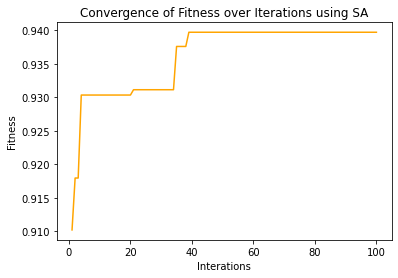

Best Individual:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Best individual accuracy:  1.0
Best individual fitness:  0.9553374988221943
No of selected features:  2


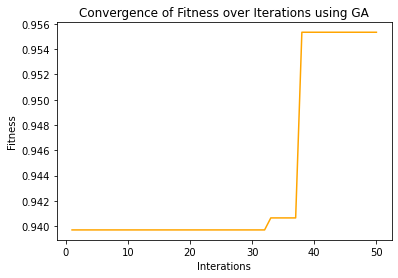

In [16]:
alpha = 0.80
gamma = 0.70
population_size = 30
num_generations = 50

# ======================.  SA    =========================
print("population size: ", population_size)
print('\nSIMULATED ANNEALING\n')
population, sa_fitness, sa_accuracy = get_population(population_size)
display_results()
#######
sa_pop_fit, sa_pop_acc, sa_pop_no_of_fe = [], [], []
for i in range(0, 30):
    df_draft = sa_all_population_run_wise[i]
    sa_pop_fit.append(df_draft['fitness'])
    sa_pop_acc.append(df_draft['accuracy'])
    sa_pop_no_of_fe.append(df_draft['no_of_features'])
# now do iter wise mean (column wise mean)
sa_pop_fit, sa_pop_acc, sa_pop_no_of_fe = np.array(sa_pop_fit), np.array(sa_pop_acc), np.array(sa_pop_no_of_fe)

mean_fit = np.max(sa_pop_fit, axis = 0)
mean_acc = np.max(sa_pop_acc, axis = 0)
mean_no_of_fe = np.max(sa_pop_no_of_fe, axis = 0)
# set the gbest
gbest_fit, gbest_acc = mean_fit[0], mean_acc[0]
gbest_fitness, gbest_accuracy = [], []
for i in range(0, len(mean_fit)):
    if(mean_fit[i]>gbest_fit):
        gbest_fit = mean_fit[i]
        gbest_fitness.append(gbest_fit)
    else:
        gbest_fitness.append(gbest_fit)
for i in range(0, len(mean_acc)):
    if(mean_acc[i]>gbest_acc):
        gbest_acc = mean_acc[i]
        gbest_accuracy.append(gbest_acc)
    else:
        gbest_accuracy.append(gbest_acc)

runs = np.arange(1, len(mean_fit[0:100])+1, 1)
plt.plot(runs, gbest_fitness[0:100], color='orange', linewidth = 1.5)
#plt.plot(runs, gbest_accuracy[0:100], label = 'accuracy', linewidth = 0.5)
#plt.legend()
plt.xlabel('Interations')
plt.ylabel('Fitness')
plt.title('Convergence of Fitness over Iterations using SA')
plt.savefig('Leukaemiamattest_sa.pdf')
plt.savefig('Leukaemiamattest_sa.png')
plt.show()

# =====================   GA.   ==========================
algo = Genetic_Algorithm(max_iter = 30)
solution = algo.run()
best_ind, best_ind_acc, best_ind_fit, no_of_selected = algo.get_results()
#fig = algo.plot()
print("Best Individual: ", best_ind)
print("Best individual accuracy: ", best_ind_acc)
print("Best individual fitness: ", best_ind_fit)
print("No of selected features: ", no_of_selected)
ga_mean_fit, ga_mean_acc = [], []
for i in range(0, len(ga_run_wise_accuracy)):
    ga_mean_fit.append(np.max(ga_run_wise_fitness[i]))
    ga_mean_acc.append(np.max(ga_run_wise_accuracy[i]))

runs = np.arange(1, len(ga_mean_fit)+1, 1)
plt.plot(runs, ga_mean_fit, color='orange', linewidth = 1.5)
#plt.plot(runs, ga_mean_acc, label = 'accuracy', linewidth = 0.5)
#plt.legend()
plt.xlabel('Interations')
plt.ylabel('Fitness')
plt.title('Convergence of Fitness over Iterations using GA')
plt.savefig('Leukaemiamattest_ga.pdf')
plt.savefig('Leukaemiamattest_ga.png')
plt.show()